<a href="https://colab.research.google.com/github/storimaging/Notebooks/blob/main/Restoration/TVICE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TV - Iterated Conditional Expectation

**Authors:**
* [Julie Delon](https://github.com/judelo)
* Lucía Bouza

## Introduction 

This notebook implements image denoising using Iterated Conditional Expectation for the TV-L2 model, as presented in the paper [Louchet, C.,  Moisan, L., *Total variation denoising using iterated conditional expectation*. In 2014 22nd European Signal Processing Conference (EUSIPCO) (pp. 1592-1596). 2014](https://hal.archives-ouvertes.fr/hal-01214735). 

Suppose we observe an image $u_0$ on a finite grid $\Omega$, that is a noisy version of an unknown image $u$, i.e. $u_0 = u + n$ with $n$ an i.i.d. Gaussian noise of variance $\sigma^2$. Assuming a prior model $p(u) \propto e^{-\lambda TV(u)}$ on the images, we can write a posterior distribution

$$ \pi(u) = p(u|u_0) \propto p(u_0|u)p(u) \propto e^{-\frac{\|u-u_0\|^2}{2\sigma^2}} e^{-\lambda TV(u)} $$

with 
- $TV(u) = \sum_{i \in \Omega, j \in N(i)} |u(i) - u(j)|$ 
- $N(i)$ the set of 4 direct neighbors of $i$ in the grid $\Omega$ 
- and the convention that $|u(i)-u(j)| = 0$ if $j \notin \Omega$. 

Computing the maximum of this posterior distribution can be done very simply by minimizing $-log(p(u|u_0))$, which is equivalent to minimizing the convex function:

$$\frac{\|u-u_0\|^2}{2\sigma^2} + \lambda TV(u).$$

This energy can be minimized for example with the algorithm of Chambolle and Pock [Antonin Chambolle, Thomas Pock. A first-order primal-dual algorithm for convex problems with applications to imaging. 2010. hal-00490826](https://hal.archives-ouvertes.fr/hal-00490826/document).

Alternatively, one can calculate the mean (expectation) of this posterior distribution, which is the conditional expectation:

$$ \mathbb{E}_{U \sim p(u)} [U|u_0] = \int_{\mathbb{R}^{|\Omega|}} u.p(u|u_0)du .$$

This integral in high dimension is difficult to estimate. One possibility is to sample according to the posterior distribution thanks to a Markov Chain Monte Carlo type algorithm and to average the samples to estimate this conditional expectation, but the speed of convergence is then $\frac{1}{\sqrt{n}}$ with $n$ the number of iterations of the algorithm.

In this notebook, we will investigate an alternative method for computing an approximate version of this conditional expectation without having to sample $ \pi(u)= p(u|u_0) $.

## Iterated conditional expectation

For any pixel $i \in \Omega$, let us denote $i^c  = \Omega$\\{$i$} . The law of the value $u(i)$ knowing $u_0$ can be written as a marginal of the law $\pi$, that is

$$ \pi(u(i)) = \int_{\mathbb{R}^{|\Omega|-1}}\pi(u)du_{|i^c}.$$

If it is very complicated to calculate this marginal law, the conditional marginal law $\pi(u(i) | u(i^c))$ is much simpler.

**Question 1** 

Show that for any pixel $i$, this conditional marginal law can be written as 

$$\pi(u(i) | u(i^c)) \propto e^{-\frac{\|u(i)-u_0(i)\|^2}{2\sigma^2}} e^{-\lambda \sum_{j \in N(i)} |u(i) - u(j)| }.$$



**TV-ICE**

The idea of the TV-ICE (Iterated Conditional Expectation) algorithm is to replace the posterior mean $\int_{\mathbb{R}^{|\Omega|}}u\pi(u)du$ by successive iterations of the means of all these conditional marginals. The algorithm thus consists in iterating:

$$ \forall i \in \Omega, \quad u_{k+1}(i) = \mathbb{E}_{U \sim \pi} [U(i)|U(i^c) = u_k(i^c)].$$

It is possible to show ([paper](https://hal.archives-ouvertes.fr/hal-01214735)) that this algorithm converges linearly to an asymptotic image
$\hat{u}_{ICE}$ regardless to the initialization $u_0$, and that this limit satisfies

$$ \forall i \in \Omega, \quad \hat{u}_{ICE}(i) = \mathbb{E}_{U \sim \pi} [U(i)|U(i^c) = \hat{u}_{ICE}(i^c)].$$

**Question 2**

Show that for any image $w$ of the same size as $u_0$

$$ \mathbb{E}_{U \sim \pi} [U(i)|U(i^c) = w(i^c)] = u_0(i) + \frac{1}{Z}\int_{\mathbb{R}} s e^{-\frac{1}{2\sigma^2}s^2 -\lambda \sum_{j \in N(i)} |s + u_0(i) - w(j)|}ds ,$$ 

where $Z$ is a constant to be specified.



## Algorithm

For $i$ fixed, we note $t = u_0(i)$ and we order the 4 values of $\{w(j)\}_{j \in N(i)}$ wich we note $a \leq b \leq c \leq d$. Thus we wish to compute:

$$ \mathbb{E}_{U \sim \pi} [U(i)|U(i^c) = w(i^c)] = t + \frac{1}{Z}\int_{\mathbb{R}} s e^{-\frac{1}{2\sigma^2}s^2 -\lambda ( |s + t - a| + |s + t - b| + |s + t - c| + |s + t - d|)}ds.$$

This integral is computed by dividing it on the intervals on which the absolute values have constant signs. We will admit that we end up with the following formula:

$$ \mathbb{E}_{U \sim \pi} [U(i)|U(i^c) = w(i^c)] = t + 2\sigma^2 \lambda \frac{2X_{-2} + X_{-1} - X_{1} -2X_{2}} {X_{-2} + X_{-1} + X_{0} + X_{1} + X_{2}}
$$

with
- $X_{-2} = \mathrm{erfc}\left(\frac{t-a+4\lambda\sigma^2}{\sigma \sqrt{2}}\right) \mathrm{exp}(2\lambda(2(t+2\lambda\sigma^2) -a -b))$
- $X_{-1} = \left(\mathrm{erf}\left(\frac{b-t-2\lambda\sigma^2}{\sigma \sqrt{2}}\right)-\mathrm{erf}\left(\frac{a-t-2\lambda\sigma^2}{\sigma \sqrt{2}}\right)\right) \mathrm{exp}(\lambda(2(t-b)+2\lambda\sigma^2))$
- $X_0 = \mathrm{erf}\left(\frac{c-t}{\sigma \sqrt{2}}\right) - \mathrm{erf}\left(\frac{b-t}{\sigma \sqrt{2}}\right)$
- $X_1 = \left(\mathrm{erf}\left(\frac{d-t+2\lambda\sigma^2}{\sigma \sqrt{2}}\right)-\mathrm{erf}\left(\frac{c-t+2\lambda\sigma^2}{\sigma \sqrt{2}}\right)\right) \mathrm{exp}(\lambda(2(c-t)+2\lambda\sigma^2)) $
- $X_2 = \mathrm{erfc}\left(\frac{d-t+4\lambda\sigma^2}{\sigma \sqrt{2}}\right) \mathrm{exp}(2\lambda(c + d- 2(t -2\lambda\sigma^2))),$
where the functions erf and erfc are respectively:
- the error function $\mathrm{erf}(x) = \frac{2}{\sqrt{\pi}}\int_0^xe^{-t^2}dt$
- the complementary error function $\mathrm{erfc}(x) = \frac{2}{\sqrt{\pi}}\int_x^{+\infty} e^{-t^2}dt$.


A naive implementation of the previous formula raises numerical problems. To avoid them, we will write the iterative TV-ICE algorithm in the following form:

- **Data**: noisy image $u_0$ , parameters $\sigma$, $\lambda$ and number of iterations $n$
- **Result**: estimation $u$ of $\hat{u}_{ICE}$ 

Initialization $u \leftarrow u_0$; \\
**for** $k \leftarrow 1$ to $n$ **do** \\
> **for** $i \in \Omega$ **do** \\
>>    Sort the values of the 4 neighbors of $i$: $a \leq b  \leq c \leq d$; \\
>>    Compute $(log X_k)_{-2 \leq k \leq 2}$; \\
>>    $M \leftarrow max_{-2 \leq k \leq 2}log X_k$; \\
>>    $X'_k \leftarrow \mathrm{exp}(logX_k - M), -2 \leq k \leq 2$; \\
>>    $\tilde{u}(i) \leftarrow u_0(i) + 2\sigma^2 \lambda \frac{2X'_{-2} + X'_{-1} - X'_{1} -2X'_{2}} {X'_{-2} + X'_{-1} + X'_{0} + X'_{1} + X'_{2}}$ 

> **end** \\
> $u \leftarrow \tilde{u}$

**end**


**Question 3:** Explain why the previous algorithm is a good solution to implement the iterations. Why is it necessary to use the logarithms? Why does one have to remove $M$ from all $log X_k$ values? Illustrate the interest of this manipulation on a simple numerical calculation.

**Question  4:**  Implement  (see the section below) the  previous  algorithm  and  test  it  to  calculate  $\hat{u}_{ICE}$  on  an  image  of  your choice. Try to avoid looping over the pixels by vectorizing the image update. The total number $n$ of iterations over the entire image can be chosen quite small in practice (between 50 and 100).
You can choose values of $\sigma$ and $\lambda$ in the same way as in the sampling tutorial for example.

**Question 5:** Compare the result obtained with the Maximum A Posteriori (MAP) for the same problem (you can compute it with the Chambolle-Pock algorithm), for equivalent parameters. Comment.

**Question 6:** Show experimentally that the speed of convergence of the iterates $u^k$ to their limit $u^{\infty}$ is linear, i .e.

$ \|u^k - u^{\infty}\|_2 = O(\alpha^n)$ with $0 \leq \alpha < 1$.

## Implementation

**Importing Packages**

Below is a list of required packages.

- `matplotlib.pyplot, BytesIO, urlopen` (load and display images)
- `scipy.special`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO                 # used for importing online images 
from urllib.request import urlopen     # used for importing online images 
import scipy.special

import warnings 
warnings.filterwarnings('ignore')

In order to implement the method we need two functions  `logerfc` and `logerf2` that are provided below. The `logerfc` function calculates the logarithm of the complementary error function erfc. The `logerf2` function calculates the logarithm of
$\mathrm{erf}(b) - \mathrm{erf}(a)$ with $a < b$. 


In [2]:
def logerfc(t):
    """
    out = logerfc(t): compute an accurate a estimate of log(erfc(t))
    """
    out = np.zeros(t.shape) 
    id = t < 20.
    out[id] = np.log(scipy.special.erfc(t[id])) 
    
    c = np.cumprod(np.arange(1,16,2)/2) 
    t2n0 = t[id==0]**2
    t2n = np.copy(t2n0) 
    S = np.ones((t2n.size,)) 
    
    p = -1
    for n in range(8):
        S = S + (p * c[n]) / t2n 
        t2n = t2n*t2n0 
        p = -p 
    out[id==0] = -t2n0 + np.log(S/(t[id==0]*np.sqrt(np.pi))) 
    return out


def logerf2(a,b):
    """
    usage: out = logerf2(a,b) with a < b
    computes an accurate estimate of log(erf(b)-erf(a))
    """
    a0 = np.copy(a)
    id = (b < 0)
    a[id] = -b[id]
    b[id] = -a0[id]

    out = np.zeros(a.shape) 
    id1 = (b-a)/(np.abs(a)+np.abs(b)) < 1e-14 
    out[id1] = np.log(2*(b[id1]-a[id1])/np.sqrt(np.pi)) - b[id1]**2 

    id2 = (id1==0) & (a<1) 
    out[id2] = np.log(scipy.special.erf(b[id2])-scipy.special.erf(a[id2])) 

    id3 = (id1==0) & (id2==0) 
    m = logerfc(b[id3]) 
    out[id3] = m + np.log(np.expm1(logerfc(a[id3])-m)) 
    
    return out

Try to implement the TV-ICE algorithm using the previous functions. The solution is provided in the following hidden cell.

In [3]:
#@title 
def tvice(u0,sig,lambd,niter): 
    """
    usage: out = tvice(u0,sigma,lambda,niter) 
    TV-ICE denoising algorithm (vectorized version)
    """
    u = np.copy(u0)
    nr,nc = u0.shape
    v = np.zeros((nr,nc,4)) 
      
    log_X = np.zeros((nr,nc,5)) 
    lambda_nrm = lambd/(2*sig**2) 
    sigma_nrm = sig*np.sqrt(2) 
    

    ## main loop 
    for iter in range(niter):
        
        # update image
        v[:,:,0] = np.hstack([u[:,0:1],u[:,0:-1]])  # right
        v[:,:,1] = np.hstack([u[:,1:] ,u[:,-1:]])    # left
        v[:,:,2] = np.vstack([u[0:1,:],u[0:-1,:]])  # bottom
        v[:,:,3] = np.vstack([u[1:,:] ,u[-1:,:]])    # top
        s = np.sort(v,2)
        A = np.reshape(s[:,:,0],[nr,nc])
        B = np.reshape(s[:,:,1],[nr,nc])
        C = np.reshape(s[:,:,2],[nr,nc])
        D = np.reshape(s[:,:,3],[nr,nc])
        
        log_X[:,:,0] = logerfc((u0-A+2*lambd*2*sig**2)/sigma_nrm) + 2*lambd*(2*(u0+lambd*2*sig**2)-A-B) # log_Xm2
        log_X[:,:,1] = logerf2((A-u0-lambd*2*sig**2)/sigma_nrm,(B-u0-lambd*2*sig**2)/sigma_nrm) + lambd*(2*(u0-B)+2*sig**2*lambd) # log_Xm1
        log_X[:,:,2] = logerf2((B-u0)/sigma_nrm , (C-u0)/sigma_nrm) # log_X0
        log_X[:,:,3] = logerf2((C-u0+lambd*2*sig**2)/sigma_nrm,(D-u0+lambd*2*sig**2)/sigma_nrm) + lambd*(2*(C-u0)+2*sig**2*lambd) # log_Xp1
        log_X[:,:,4] = logerfc((D-u0+2*lambd*2*sig**2)/sigma_nrm) + 2*lambd*(C+D-2*(u0-2*sig**2*lambd)) # log_Xp2
            
        M = np.reshape(np.max(log_X,2),[nr,nc])
        XXm2 = np.exp(log_X[:,:,0]-M)
        XXm1 = np.exp(log_X[:,:,1]-M)
        XX0  = np.exp(log_X[:,:,2]-M)
        XXp1 = np.exp(log_X[:,:,3]-M)
        XXp2 = np.exp(log_X[:,:,4]-M)
        u = u0 + 2*sig**2*lambd * (2*XXm2 + XXm1 - XXp1 - 2*XXp2) / (XXm2 + XXm1 + XX0 + XXp1 + XXp2) 
 
    return u

The following cell contains the code for the Chambolle-Pock algorithm that we will use to compare the solution of the TV-ICE algorithm with the MAP of the same TV-L2 model.

In [4]:
#@title 

def div(cx,cy):
    """
    cy and cy are coordonates of a vector field.
    #the function computes the discrete divergence of this vector field
    """
    nr,nc=cx.shape

    ddx=np.zeros((nr,nc))
    ddy=np.zeros((nr,nc))

    ddx[:,1:-1]=cx[:,1:-1]-cx[:,0:-2]
    ddx[:,0]=cx[:,0]
    ddx[:,-1]=-cx[:,-2]
  
    ddy[1:-1,:]=cy[1:-1,:]-cy[0:-2,:]
    ddy[0,:]=cy[0,:]
    ddy[-1,:]=-cy[-2,:]
 
    d=ddx+ddy

    return d


def grad(im):
    """
    computes the gradient of the image 'im'
    """
    nr,nc=im.shape
  
    gx = im[:,1:]-im[:,0:-1]
    gx = np.block([gx,np.zeros((nr,1))])

    gy =im[1:,:]-im[0:-1,:]
    gy=np.block([[gy],[np.zeros((1,nc))]])
    return gx,gy

def chambolle_pock_prox_TV(TV,ub,lambd,niter, **opts):
    """
    the function solves the problem
    - TVL2
       argmin_u   1/2 \| u - ub\|^2 + \lambda TV(u)
    - or TVL2A
       argmin_u   1/2 \| Au - ub\|^2 + \lambda TV(u)
       with A = diagonal matrix represented by the mask send as an opt on parameters
    - or TVL1
       argmin_u   1/2 \| u - ub\|_1 + \lambda TV(u)
    with TV(u) = \sum_i \|\nabla u (i) \|_2
    uses niter iterations of Chambolle-Pock
    """

    nr,nc = ub.shape
    ut = np.copy(ub)
    ubar = np.copy(ut)
    p = np.zeros((nr,nc,2))
    tau = 0.9/np.sqrt(8*lambd**2)
    sigma = 0.9/np.sqrt(8*lambd**2) 
    theta = 1
    
    # For TVL2A case
    mask = opts.get('mask', np.ones_like(ub))
    
    for k in range(niter):
        # Calcul de proxF
        ux,uy  = grad(ubar)
        p = p + sigma*lambd*np.stack((ux,uy),axis=2)
        normep = np.sqrt(p[:,:,0]**2+p[:,:,1]**2)
        normep = normep*(normep>1) + (normep<=1)
        p[:,:,0] = p[:,:,0]/normep
        p[:,:,1] = p[:,:,1]/normep

        # Calcul de proxG
        d=div(p[:,:,0],p[:,:,1])
        if (TV == "TVL2"):
            unew = 1/(1+tau)*(ut+tau*lambd*d+tau*ub) 
        elif (TV == "TVL2A"):    
            unew = 1/(1+tau*mask)*(ut+tau*lambd*d+tau*mask*ub)
        else:
            uaux = ut+tau*lambd*d
            unew = (uaux-tau)*(uaux-ub>tau)+(uaux+tau)*(uaux-ub<-tau)+ub*(abs(uaux-ub)<=tau)
        
        # Extragradient step
        ubar = unew+theta*(unew-ut)
        ut = np.copy(unew)
           
    return ut


**Load and create the noisy image**

In the next cell we will create a noisy image. We will crop the original image to accelerate the process. 

In [5]:
# Read the image
IMG = "https://raw.githubusercontent.com/storimaging/Images/main/img/simpson_nb512.png"
u = plt.imread(BytesIO(urlopen(IMG).read()))

# Crop image: start with small images for your experimentations
n = 100    
i = 100
u = u[i:i+n,i:i+n]

# Add noise
nr,nc = u.shape
sigma = 0.05
ub = u + sigma*np.random.randn(nr,nc)

**Run algorithm**

In the next cell we will run the TV-ICE algorithm. We will also run the Chambolle-Pock TV-L2 algorithm for comparison purposes.

<Figure size 720x720 with 0 Axes>

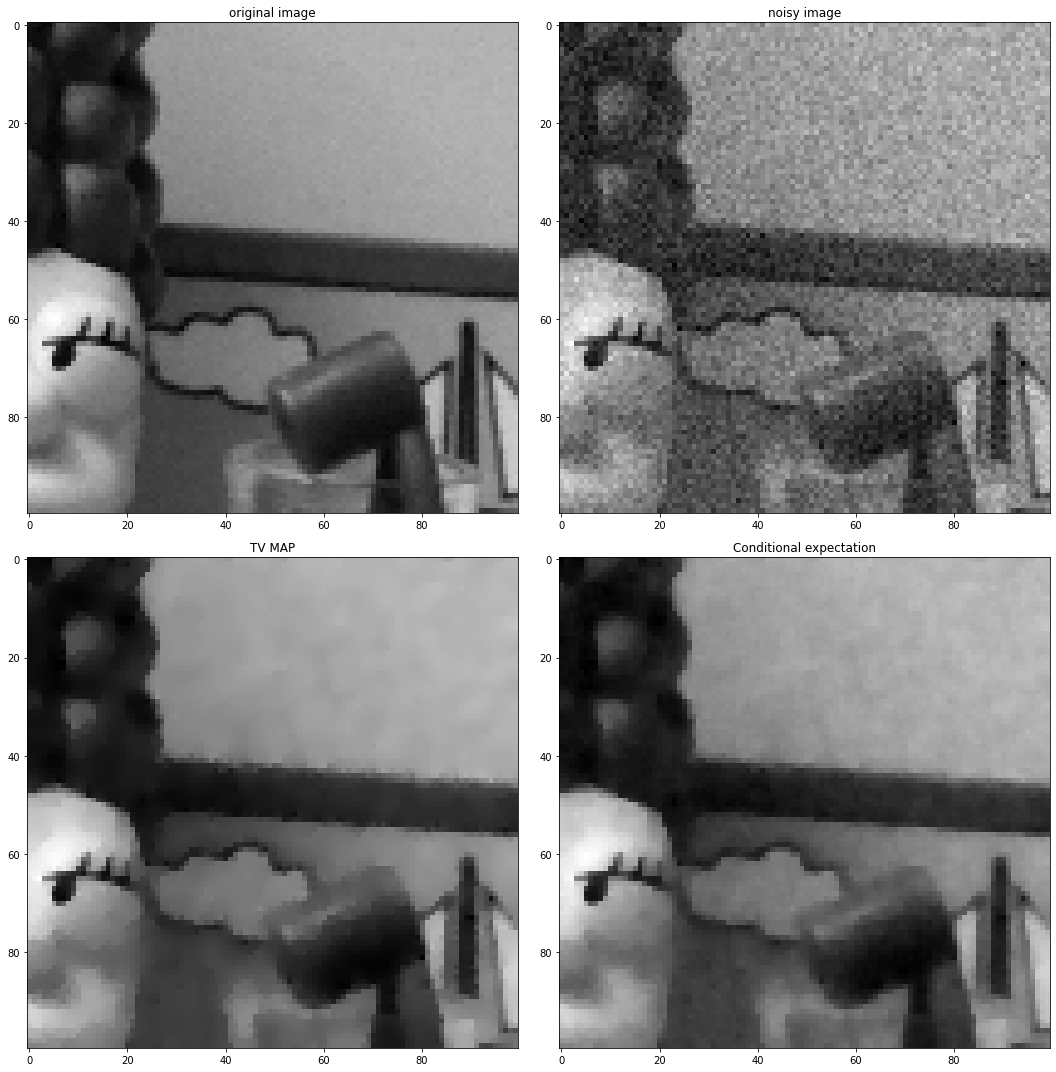

<Figure size 720x720 with 0 Axes>

In [6]:
# TV regularization parameter 
lambd = 20

## TV-ICE
u_denoised = tvice(ub,sigma,lambd,100)

# TV-MAP
u_tvmap = chambolle_pock_prox_TV("TVL2",ub,sigma**2*lambd,100)

## display results
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
axes[0,0].imshow(u,cmap='gray')
axes[0,0].set_title('original image')
axes[0,1].imshow(ub,cmap='gray')
axes[0,1].set_title('noisy image')
axes[1,0].imshow(u_tvmap,cmap='gray')
axes[1,0].set_title('TV MAP')
axes[1,1].imshow(u_denoised,cmap='gray')
axes[1,1].set_title('Conditional expectation')
fig.tight_layout()
plt.figure(figsize = (10,10))